In [1]:
import sys

sys.path.append("C:/Users/junsu/volatility_arbitrage")

In [4]:
from volatility_arbitrage.pricing_model.interface import HestonParams
from volatility_arbitrage.pricing_model.heston_model import generate_cir_processs
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ncx2
import pandas as pd

In [3]:
BDAYS = 252

length = BDAYS
time_delta = 1 / BDAYS
realized_vol = 0.16
num_path = 100_000

heston_model = HestonParams(kappa=5, mean_of_var=realized_vol**2, vol_of_var=0.5, rho=-0.4)
np.random.seed(0)
normal_var = np.random.normal(size=(length, num_path))
var = generate_cir_processs(
    var_0=realized_vol**2,
    model_params=heston_model,
    normal_var=normal_var,
    num_path=num_path,
    length=length,
    time_delta=time_delta,
)

# Transition density & Moment

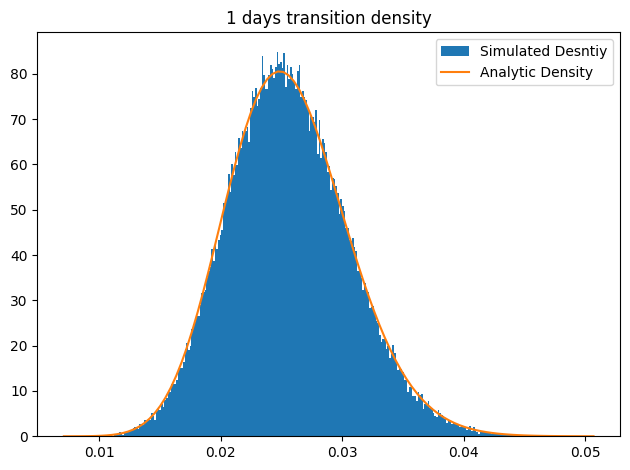

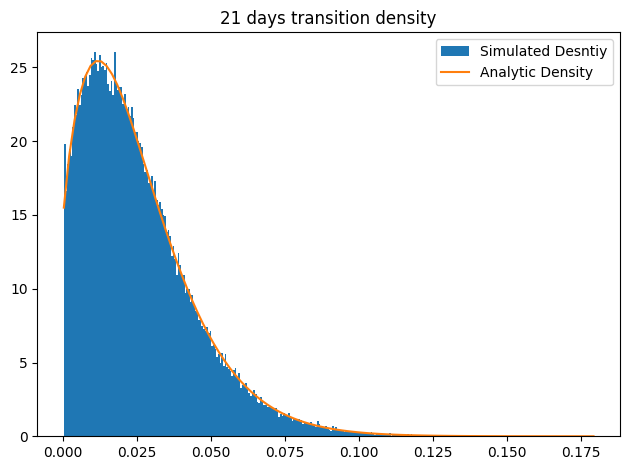

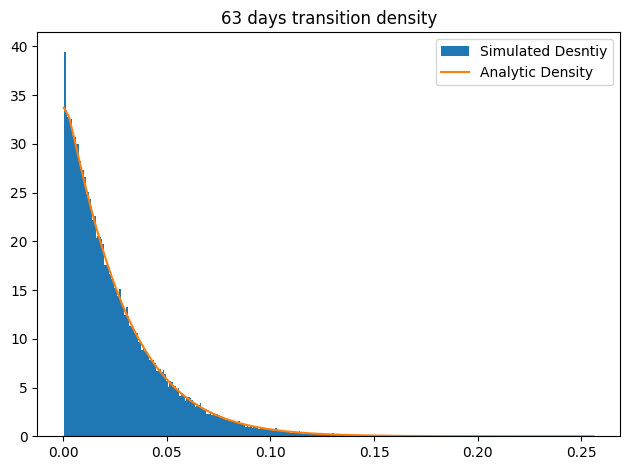

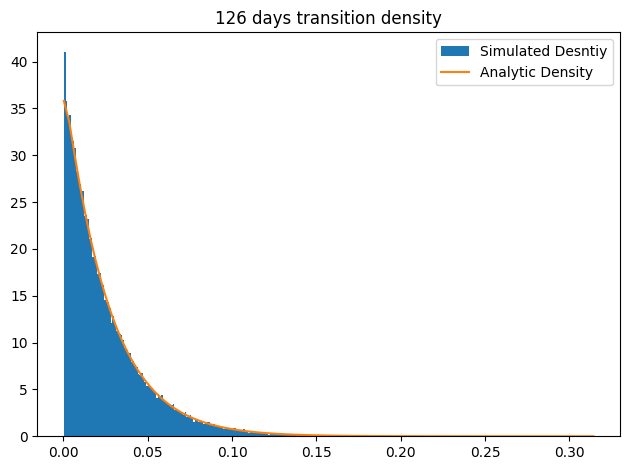

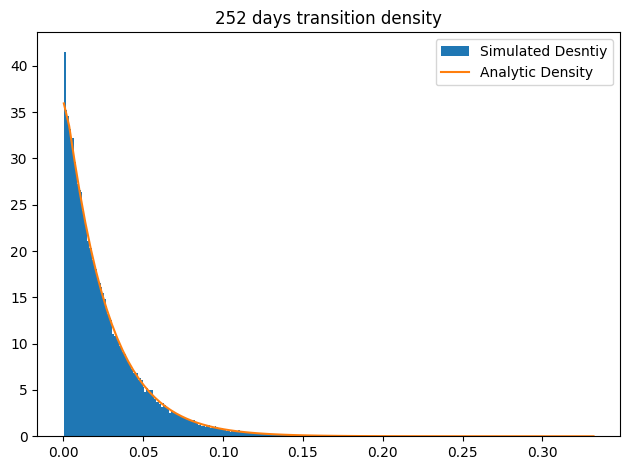

Mean           Variance          
     Simulated Analytic Simulated  Analytic
Days                                       
1     0.025606   0.0256  0.000024  0.000025
21    0.025664   0.0256   0.00036  0.000362
63    0.025637   0.0256  0.000583  0.000587
126    0.02565   0.0256   0.00063  0.000636
252   0.025577   0.0256  0.000635   0.00064

In [6]:
dof = 4 * heston_model.kappa * heston_model.mean_of_var / heston_model.vol_of_var**2
stats = pd.DataFrame(
    columns=pd.MultiIndex.from_product([["Mean", "Variance"], ["Simulated", "Analytic"]]),
    index=pd.Index([1, 21, 63, 126, 252], name="Days"),
)
for days in (1, 21, 63, 126, 252):
    c = (
        2
        * heston_model.kappa
        / ((1 - np.exp(-heston_model.kappa * days / BDAYS)) * heston_model.vol_of_var**2)
    )
    non_centrality = 2 * c * realized_vol**2 * np.exp(-heston_model.kappa * days / BDAYS)
    x = np.linspace(np.min(2 * c * var[days]), np.max(2 * c * var[days]), 100)
    analytic_pdf = ncx2.pdf(x, df=dof, nc=non_centrality) * 2 * c
    analytic_mean = ncx2.mean(df=dof, nc=non_centrality) / (2 * c)
    analytic_var = ncx2.var(df=dof, nc=non_centrality) / (2 * c) ** 2

    simulated_mean = np.mean(var[days])
    simulated_var = np.var(var[days], ddof=1)

    stats.loc[days] = [simulated_mean, analytic_mean, simulated_var, analytic_var]

    plt.hist(var[days], bins=int(np.sqrt(num_path)), density=True, label="Simulated Desntiy")
    plt.plot(x / (2 * c), analytic_pdf, label="Analytic Density")
    plt.legend()
    plt.title(f"{days} days transition density")
    plt.tight_layout()
    plt.show()
display(stats)